### Imports & Setting

In [56]:
## packages imports
library(forecast) #ma
library(TTR) #sma
library(lmtest) #dwtest
library(ggplot2)

## setting
options(repr.plot.width = 15, repr.plot.height = 8)
setwd("~/TS2024/data/Time Series Data/")

### 1번 문제

In [ ]:
## load data
export = scan("export.txt")

## time series plot : total
plot.ts(export, type = 'b', col = 'darkorange', lwd = 2, pch = 16,
        main = "수출 시계열 그림", cex.main = 2)
abline(v = seq(1, 100, by = 12), lty = 2)

##-----추세 분석을 이용한 분해-----
## trend
z = ts(export, frequency = 12)
t = 1:length(z)
trend_model = lm(z~t+I(t^2))
That = fitted(trend_model)

## seasonal
adj_trend = z - That
s = factor(cycle(z))
season_model = lm(adj_trend~0+s) ## 절편이 0인 모형
Shat = fitted(season_model)

## irregular
Ihat = z - That - Shat

## time series plots : each components
layout(matrix(c(1,1,2,3), 2, 2, byrow = TRUE)) ## 2 by 2 matrix에 위치를 찍어줌.
plot.ts(That, lwd = 2, col = 'darkorange', main="추세성분 시계열 그림", cex.main = 1.5, ylab = expression(hat(T)[t]))
plot.ts(Shat, lwd = 1.5, col = 'steelblue', main="계절성분 시계열 그림", cex.main = 1.5, ylab = expression(hat(S)[t]))
plot.ts(Ihat, lwd = 1.5, col = 'red', main="불규칙성분 시계열 그림", cex.main = 1.5, ylab = expression(hat(I)[t]))
abline(h = 0, lty = 2)

## irregular term analysis
t.test(Ihat) ## 귀무가설 기각 못함
dwtest(lm(Ihat~1), alternative = "two.sided") ## 귀무가설 기각

##-----이동평균을 이용한 분해-----
## trend
trend = ma(z, 12)

## seasonal
adj_trend = z - trend
seasonal = tapply(adj_trend, cycle(adj_trend), function(y) mean(y, na.rm = T))
seasonal = seasonal - mean(seasonal) ## 계절성분의 평균을 0으로 조정
St = ts(rep(seasonal, 10)[1:86], frequency = 12)
                  
## irregular
irregular = z - trend - St

## time series plots : each components
layout(matrix(c(1,1,2,3), 2, 2, byrow = TRUE)) ## 2 by 2 matrix에 위치를 찍어줌.
a = as.vector(trend)
b = as.vector(St)
c = as.vector(irregular)
plot(a~t, type = "l", lwd = 2, col = 'darkorange', main="추세성분 시계열 그림", cex.main = 1.5, ylab = expression(hat(T)[t]), xlab = "year(12 times)")
plot(b~t, type = 'l', lwd = 1.5, col = 'steelblue', main="계절성분 시계열 그림", cex.main = 1.5, ylab = expression(hat(S)[t]), xlab = "year(12 times)")
plot(c~t, type = 'l', lwd = 1.5, col = 'red', main="불규칙성분 시계열 그림", cex.main = 1.5, ylab = expression(hat(I)[t]), xlab = "year(12 times)")
abline(h = 0, lty = 2)

## irregular term analysis
t.test(irregular) ## 귀무가설 기각 못함
dwtest(lm(irregular~1), alternative = "two.sided") ## 귀무가설 기각 못함

## 1-시차 후 예측오차의 제곱합 산출
Zhat_trend = That + Shat
print(sum((z - Zhat_trend)^2))
Zhat_MA = trend + St
print(sum((z - Zhat_MA)^2, na.rm = TRUE))

### 2번 문제

In [ ]:
## data load
usapass = scan('usapass.txt')
z = ts(log(usapass), frequency = 12)

## time series plot : 원자료
# plot.ts(usapass, type = 'b', col = 'darkorange', lwd = 2, pch = 16, xlab = 'month', ylab = 'Number of passengers',
#         main = "미국 월별 비행기 승객 수 시계열 그림", cex.main = 2)

## time series plot : 로그 변환
plot(log(usapass), type = 'b', col = 'darkorange', lwd = 2, pch = 16, xlab = 'month', ylab = expression(log(z)),
        main = "로그 변환 시계열 그림", cex.main = 2)
abline(v = seq(1, 150, by = 12), lty = 2)

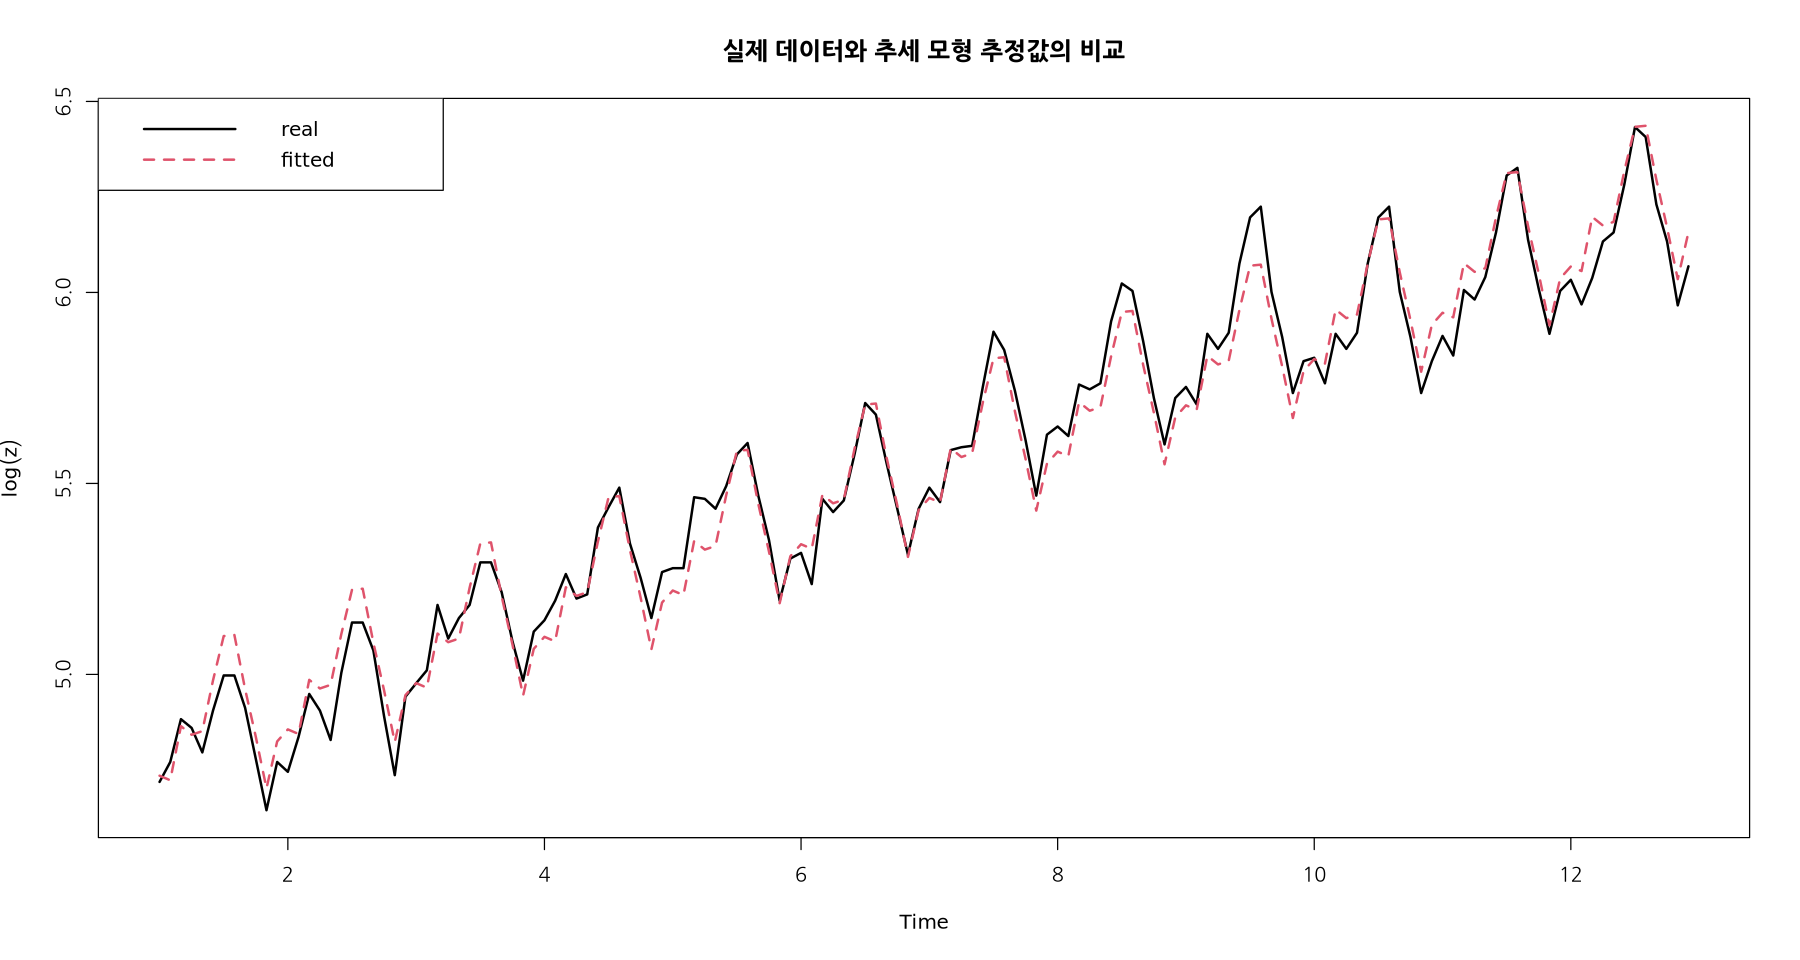


	One Sample t-test

data:  rsid
t = -4.694e-16, df = 143, p-value = 1
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.009812747  0.009812747
sample estimates:
    mean of x 
-2.330188e-18 



	Durbin-Watson test

data:  lm(rsid ~ 1)
DW = 0.40831, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is not 0



	studentized Breusch-Pagan test

data:  trend_model
BP = 5.9163, df = 12, p-value = 0.9202


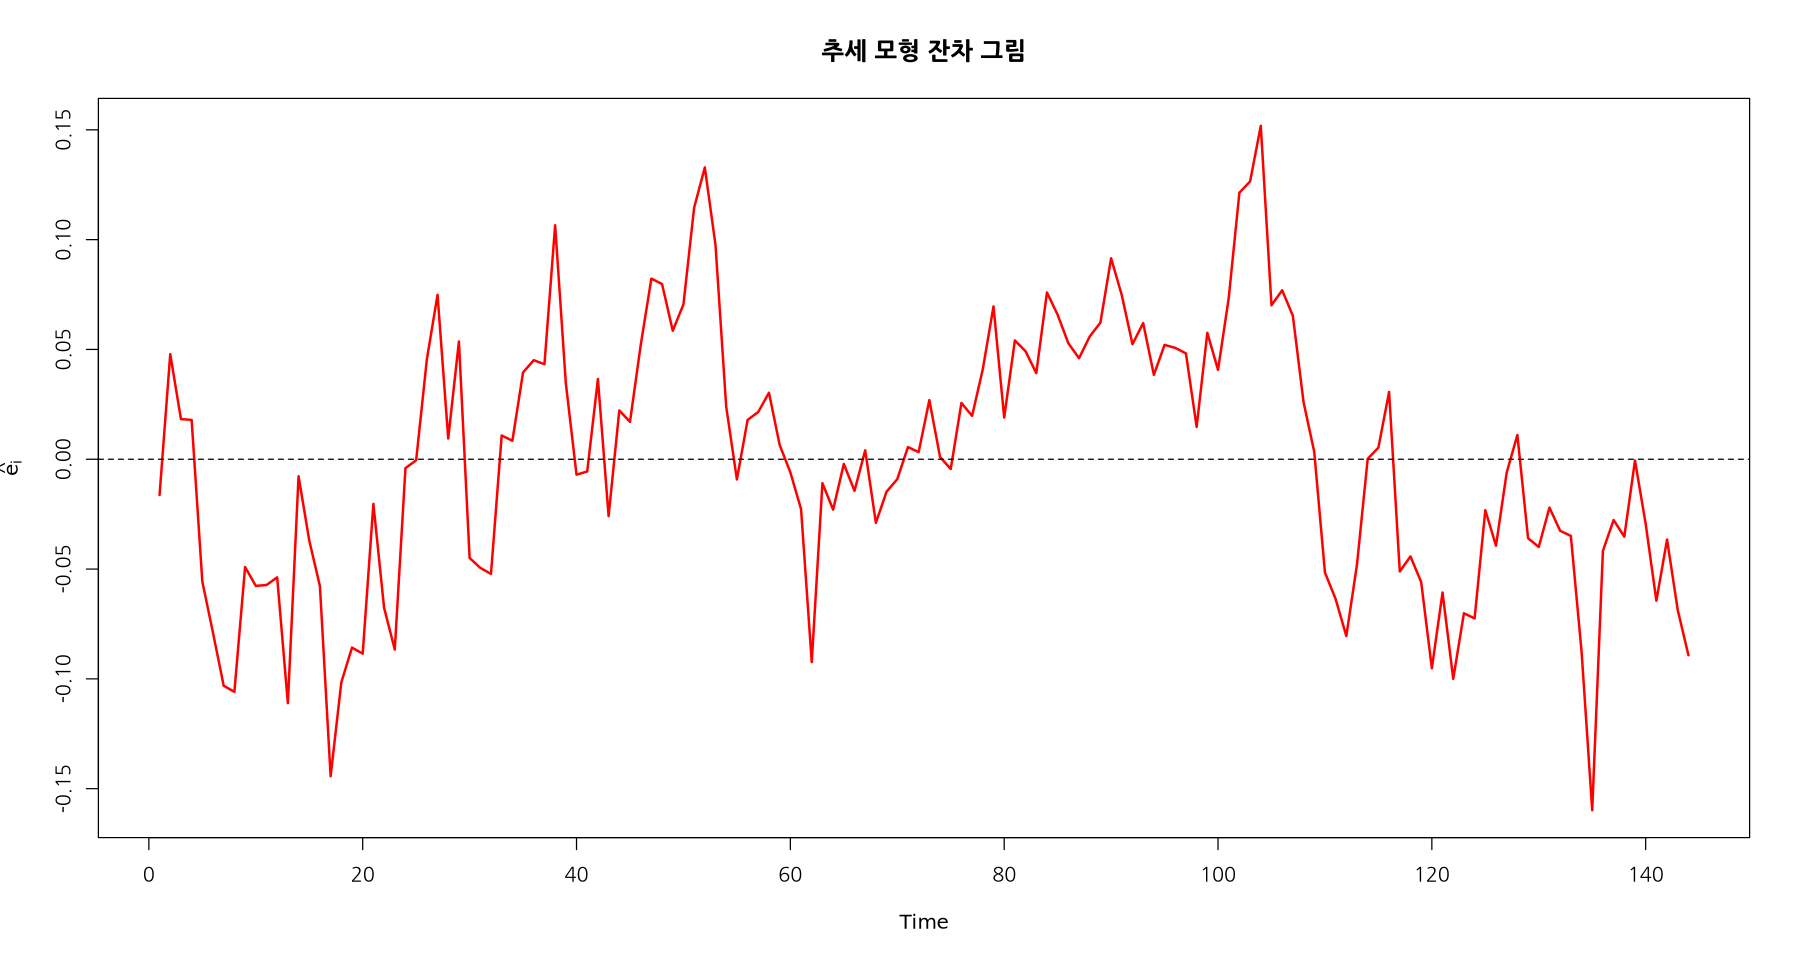

In [326]:
## 계절추세모형 적합
t = 1:length(z)
s = factor(cycle(z))
trend_model = lm(z~t+s) ## s1를 기저로 처리
rsid = resid(trend_model)

## 실제 데이터와 각 모형에서 구해진 추정값 비교
ts.plot(z, fitted(trend_model), lty = 1:2, col = 1:2, lwd = 2,
        ylab = expression(log(z)), main = "실제 데이터와 추세 모형 추정값의 비교")
legend('topleft', c("real", "fitted"), lty = 1:2, lwd = 2, col = 1:2)

## 잔차 분석
plot.ts(rsid, lwd = 2, col = 'red', ylab = expression(hat(e[i])), main = "추세 모형 잔차 그림")
abline(h = 0, lty = 2)
t.test(rsid)
dwtest(lm(rsid~1), alternative = "two.sided")
bptest(trend_model)